In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp_data_analysis.tables import tbls
import calitp_data_analysis.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
from rt_analysis import rt_filter_map_plot
import build_speedmaps_index

from IPython.display import display, Markdown, Latex, HTML, IFrame
import json
import base64

# Using module

In [2]:
from rt_analysis import signal_tools
from shared_utils import rt_utils

In [3]:
import importlib
importlib.reload(signal_tools)

<module 'rt_analysis.signal_tools' from '/home/jovyan/data-analyses/rt_delay/rt_analysis/signal_tools.py'>

In [4]:
path = './signals_2023-06-12.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

In [5]:
rt_day = rt_filter_map_plot.from_gcs(300, build_speedmaps_index.ANALYSIS_DATE)

found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_300_2023-07-12.parquet


In [6]:
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [7]:
signal_tools.generate_speedmap_buffer_signals?

Signature: signal_tools.generate_speedmap_buffer_signals(rt_day, signal_gdf)
Docstring: attach district-filtered signals to RtFilterMapper
File:      ~/data-analyses/rt_delay/rt_analysis/signal_tools.py
Type:      function

In [8]:
signal_tools.generate_speedmap_buffer_signals(rt_day, signal_gdf)
signal_tools.calculate_signal_metric(rt_day)

.signals attribute added
.signals_metrics attribute added


# Optimizing?

In [9]:
import numpy as np

In [ ]:
df = rt_day.signals_metrics

In [39]:
test_df = df >> select(_.p50_mph, _.fast_slow_ratio, _.trips_per_hour)

In [40]:
system_p50 = rt_day.detailed_map_view.p50_mph.quantile(.5)
twenty_mph = 20

In [41]:
system_p50

14.4

In [42]:
test_df >> head(3)

,p50_mph,fast_slow_ratio,trips_per_hour
2,14.1,2.3,2.3
5,14.7,3.4,3.3
6,17.3,5.3,3.3


In [50]:
decile_raw = ((test_df.p50_mph - system_p50) / system_p50) * 10
decile_rounded = np.round(decile_raw, 0).astype('int64')
# positive values are comparatively higher speeds, mask to 0 to indicate low priority
decile_masked = decile_rounded.mask(decile_rounded > 0, 0)
decile_score = np.absolute(decile_masked)

In [52]:
decile_score

2      0
5      0
6      0
9      0
11     3
      ..
450    1
451    1
452    1
453    1
476    2
Name: p50_mph, Length: 162, dtype: int64

In [46]:
variability = test_df.fast_slow_ratio
variability_low_mask = variability.mask(variability <= 1, 0)
variability_scaled = np.round(variability * 3, 0)
variability_high_mask = variability_scaled.mask(variability_scaled > 10, 10)
variability_score = variability_high_mask.astype('int64')

In [47]:
variability_score

2       7
5      10
6      10
9       5
11      3
       ..
450     4
451     4
452     4
453     4
476     6
Name: fast_slow_ratio, Length: 162, dtype: int64

In [48]:
frequency = test_df.trips_per_hour
frequency_scaled = np.round(frequency * 2, 0)
frequency_score = frequency_scaled.mask(frequency_scaled > 10, 10).astype('int64')

In [49]:
frequency_score

2      5
5      7
6      7
9      8
11     8
      ..
450    5
451    5
452    5
453    5
476    9
Name: trips_per_hour, Length: 162, dtype: int64

## Reference Histograms for subscores

<AxesSubplot:>

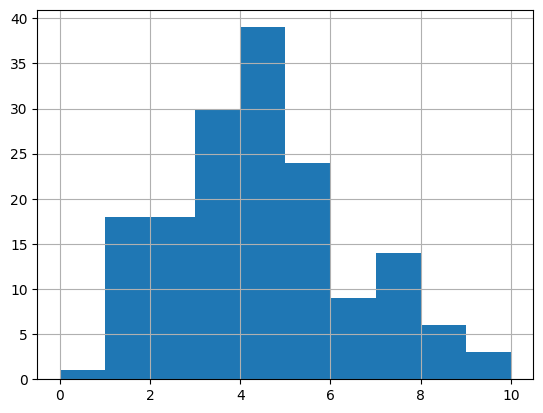

In [209]:
df.speed_score.hist()

<AxesSubplot:>

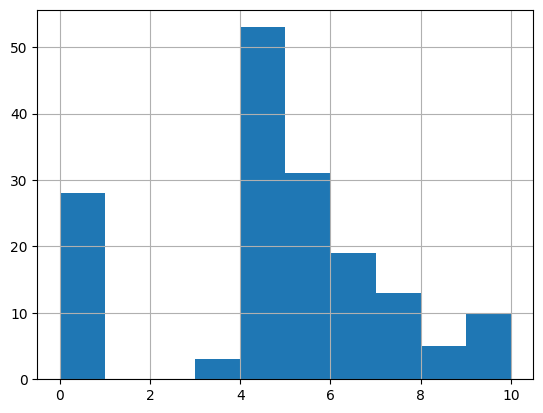

In [210]:
df.variability_score.hist()

<AxesSubplot:>

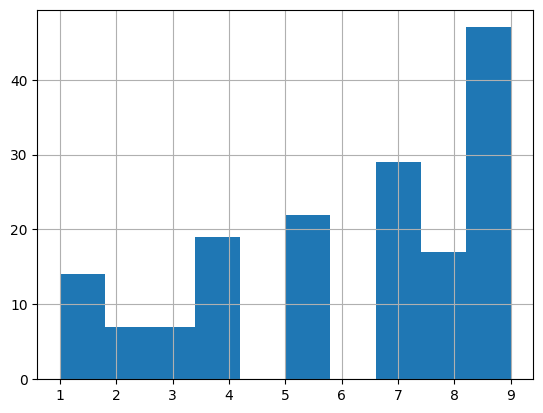

In [211]:
df.frequency_score.hist()

In [212]:
df.columns

Index(['stop_id', 'stop_name', 'geometry', 'shape_id', 'stop_sequence',
       'route_id', 'route_short_name', 'direction_id', 'p50_mph', 'p20_mph',
       'p80_mph', 'fast_slow_ratio', 'trips_per_hour', 'miles_from_last',
       'time_formatted', 'imms_id', 'location', 'start_distance',
       'end_distance', 'approaching', 'decile_from_system_p50',
       'decile_from_20mph', 'speed_score', 'variability_score',
       'frequency_score', 'combined_score'],
      dtype='object')

In [213]:
test = df >> arrange(-_.combined_score) >> head(15)

In [214]:
rt_utils.set_state_export(test,
                          filename='signal_join_test1', cache_seconds=0,
                          cmap=rt_utils.ZERO_THIRTY_COLORSCALE, color_col='p20_mph',
                          legend_url=rt_utils.SPEEDMAP_LEGEND_URL
                    )

writing to calitp-map-tiles/testing/signal_join_test1.geojson.gz


{'state_dict': {'name': 'null',
  'layers': [{'name': 'Map',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/testing/signal_join_test1.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}],
  'lat_lon': (34.02889742320673, -118.44357591292896),
  'zoom': 13,
  'legend_url': 'https://storage.googleapis.com/calitp-map-tiles/speeds_legend.svg'},
 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJNYXAiLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3Rlc3Rpbmcvc2lnbmFsX2pvaW5fdGVzdDEuZ2VvanNvbi5neiIsICJwcm9wZXJ0aWVzIjogeyJzdHJva2VkIjogZmFsc2UsICJoaWdobGlnaHRfc2F0dXJhdGlvbl9tdWx0aXBsaWVyIjogMC41fX1dLCAibGF0X2xvbiI6IFszNC4wMjg4OTc0MjMyMDY3MywgLTExOC40NDM1NzU5MTI5Mjg5Nl0sICJ6b29tIjogMTMsICJsZWdlbmRfdXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3NwZWVkc19sZWdlbmQuc3ZnIn0='}

# Score everything!

In [219]:
progress_df = pd.read_parquet('./_rt_progress_2023-07-12.parquet') >> filter(_.status == 'map_confirmed')

In [223]:
progress_df >> head(3)

,organization_name,organization_itp_id,organization_source_record_id,caltrans_district,_is_current,analysis_date,status
0,Cloverdale Transit,70,recRM3c9Zfaft4V2B,04 - Oakland,False,2023-07-12,map_confirmed
1,Sonoma County,314,recDupUxInMUgxeiz,04 - Oakland,False,2023-07-12,map_confirmed
2,Nevada County,221,reczUcQgqgtMpkpKC,03 - Marysville,True,2023-07-12,map_confirmed


In [233]:
path = './signals_2023-06-12.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

all_metric_gdfs = []
for itp_id in progress_df.organization_itp_id:
# for itp_id in [350, 4]:
    print(itp_id)
    try:
        # all-day speeds (no filter)
        rt_day = rt_filter_map_plot.from_gcs(itp_id, progress_df.analysis_date.iloc[0])
        signal_tools.generate_speedmap_buffer_signals(rt_day, signal_gdf)
        signal_tools.calculate_signal_metric(rt_day)
        
        all_metric_gdfs += [rt_day.signals_metrics]
    except Exception as e:
        print(f'{itp_id}, {e}')

70
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_70_2023-07-12.parquet
.signals attribute added
.signals_metrics attribute added
314
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_314_2023-07-12.parquet
.signals attribute added
.signals_metrics attribute added
221
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_221_2023-07-12.parquet
stop_speeds shape: (0, 17), shape_id: p_857973
stop speeds gdf is empty!
stop_speeds shape: (0, 17), shape_id: p_1277435
stop speeds gdf is empty!
.signals attribute added
.signals_metrics attribute added
350
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_350_2023-07-12.parquet
.signals attribute added
.signals_metrics attribute added
105
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_105_2023-07-12.parquet
.si

In [238]:
gdf_all = pd.concat(all_metric_gdfs)
gdf_all.to_parquet('./_signal_metrics_gdf.parquet')

In [239]:
df_all = gdf_all >> group_by(_.imms_id) >> summarize(speed_score = _.speed_score.median(),
                                            variability_score = _.variability_score.median(),
                                            frequency_score = _.frequency_score.median(),
                                            overall_transit_score = _.combined_score.median(),
                                           )
df_all.to_parquet('./_signal_metrics_df.parquet')

In [242]:
df_all = df_all.rename(columns={'imms_id': "IMMS ID"})

In [244]:
original_format = pd.read_excel('./signals_2023-06-12.xlsx') >> inner_join(_, df_all, on = ['IMMS ID'])

In [245]:
original_format.to_excel('transit_score_signals_2023-06-12.xlsx')